In [37]:
import pandas as pd
import nltk
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import torch
from transformers import pipeline
import textwrap
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gulsumasenacakir/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Data Prep

In [3]:
df = pd.read_csv("/Users/gulsumasenacakir/Downloads/elden_ring_steam_reviews.csv")

In [4]:
df.head()

,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,134238864,english,being killed over and over again is fun,2023-03-07 14:19:11,True,0,0,False,False,False,47,2,355,355,346,2023-03-07 14:29:21
1,134238208,english,I write this review as I have 100% completed E...,2023-03-07 14:03:24,True,0,0,True,False,False,110,2,24238,5823,24238,2023-03-07 02:08:22
2,134238033,english,Fun,2023-03-07 13:59:13,True,0,0,True,False,False,11,1,912,912,881,2023-03-07 14:30:07
3,134237508,english,pretty cool.,2023-03-07 13:46:37,True,0,0,True,False,False,94,8,8497,2914,8497,2023-03-07 13:44:52
4,134236511,english,AMAZINGGGGGGGGGGGGG,2023-03-07 13:20:04,True,0,0,True,False,False,4,1,985,163,923,2023-03-07 14:26:41


In [5]:
df.shape

(9794, 16)

In [6]:
df_check = pd.DataFrame({
    'unique_values': df.nunique(),
    'missing_values': df.isnull().sum(),
    'types': df.dtypes
})
df_check

,unique_values,missing_values,types
id,9794,0,int64
language,1,0,object
review,8344,29,object
created,9777,0,object
voted_up,2,0,bool
votes_up,34,0,int64
comment_count,10,0,int64
steam_purchase,2,0,bool
recieved_for_free,2,0,bool
written_during_early_access,1,0,bool


In [7]:
# remove null values
df = df.dropna()
df.shape

(9765, 16)

In [8]:
# remove the columns with the same value
df = df.drop(['language', 'written_during_early_access'], axis=1)
df.shape

(9765, 14)

In [9]:
## add new feature to count the length of review
df['length_review'] = df['review'].str.len()

In [10]:
df[['review', 'length_review']].head()

,review,length_review
0,being killed over and over again is fun,39
1,I write this review as I have 100% completed E...,3582
2,Fun,3
3,pretty cool.,12
4,AMAZINGGGGGGGGGGGGG,19


#### VADER

In [11]:
sia = SentimentIntensityAnalyzer()

In [19]:
df['sentiment_vader'] = df['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [25]:
df[df['sentiment_vader'] < 0][['review', 'sentiment_vader']]

,review,sentiment_vader
0,being killed over and over again is fun,-0.2960
4,AMAZINGGGGGGGGGGGGG,0.0000
7,"The game is super amazing and fun, easy to con...",-0.8316
8,OHHHHHHHHHHHHHHHHH ELDEN RING,0.0000
9,Liar Ahead!,-0.5562
...,...,...
9783,"I do not understand why the game is so hyped, ...",-0.8536
9784,w,0.0000
9785,what a journey,0.0000
9786,Don't give up. Don't give in. Git Gud.,0.0000


In [22]:
df['label_vader'] = df['sentiment_vader'].apply(lambda x: 'positive' if x > 0 else ('negative' if x<0 else 'neutral') )

#### BERT

In [14]:
device = 0 if torch.backends.mps.is_available() else -1  # MPS 
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)

Device set to use mps:0


In [15]:
example = df['review'][0]
example

'being killed over and over again is fun'

In [16]:
classifier(example)

[{'label': '4 stars', 'score': 0.5098581910133362}]

In [17]:
def split_text(text, chunk_size=250):
    return textwrap.wrap(text, width=chunk_size)

def analyze_review(review):
    if len(review) <= 512:
        result = classifier(review)[0]
        return result["label"], result["score"]
    else:
        chunks = split_text(review, chunk_size=512)
        results = classifier(chunks)
        avg_score = np.mean([res["score"] for res in results])
        return results[0]["label"], avg_score


In [26]:
df[["sentiment_bert", "score_bert"]] = df["review"].apply(lambda x: pd.Series(analyze_review(x)))

#### Comparison

In [29]:
df[['review', 'label_vader', 'sentiment_bert']].head(10)

,review,label_vader,sentiment_bert
0,being killed over and over again is fun,negative,4 stars
1,I write this review as I have 100% completed E...,positive,5 stars
2,Fun,positive,4 stars
3,pretty cool.,positive,4 stars
4,AMAZINGGGGGGGGGGGGG,neutral,5 stars
5,good\n\n,positive,4 stars
6,Yes very hard but very fun also Berserk.,positive,4 stars
7,"The game is super amazing and fun, easy to con...",negative,4 stars
8,OHHHHHHHHHHHHHHHHH ELDEN RING,neutral,5 stars
9,Liar Ahead!,negative,1 star


In [33]:
vader_labels = df.groupby('label_vader')['id'].count().reset_index().rename(columns = {'id': 'cnt_vader'})
vader_labels

,label_vader,cnt_vader
0,negative,1565
1,neutral,2491
2,positive,5709


In [35]:
def label_posneg_net(sentiment_bert):
    if sentiment_bert == '1 star' or sentiment_bert == '2 stars':
        return 'negative'
    elif sentiment_bert == '3 stars':
        return 'neutral'
    else:
        return 'positive'
       

In [36]:
bert_labels = df.groupby('sentiment_bert')['id'].count().reset_index().rename(columns = {'id': 'cnt_bert'})
bert_labels['label_bert'] = bert_labels['sentiment_bert'].apply(lambda x: label_posneg_net(x))
bert_labels

,sentiment_bert,cnt_bert,label_bert
0,1 star,1477,negative
1,2 stars,436,negative
2,3 stars,1069,neutral
3,4 stars,1899,positive
4,5 stars,4884,positive


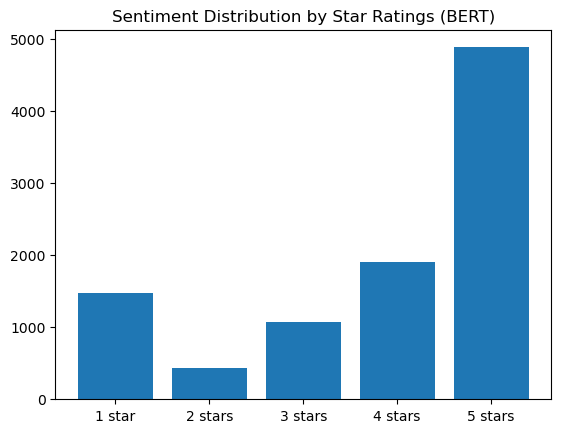

In [45]:
plt.bar(bert_labels['sentiment_bert'], bert_labels['cnt_bert'] )
plt.title('Sentiment Distribution by Star Ratings (BERT)')
plt.show()

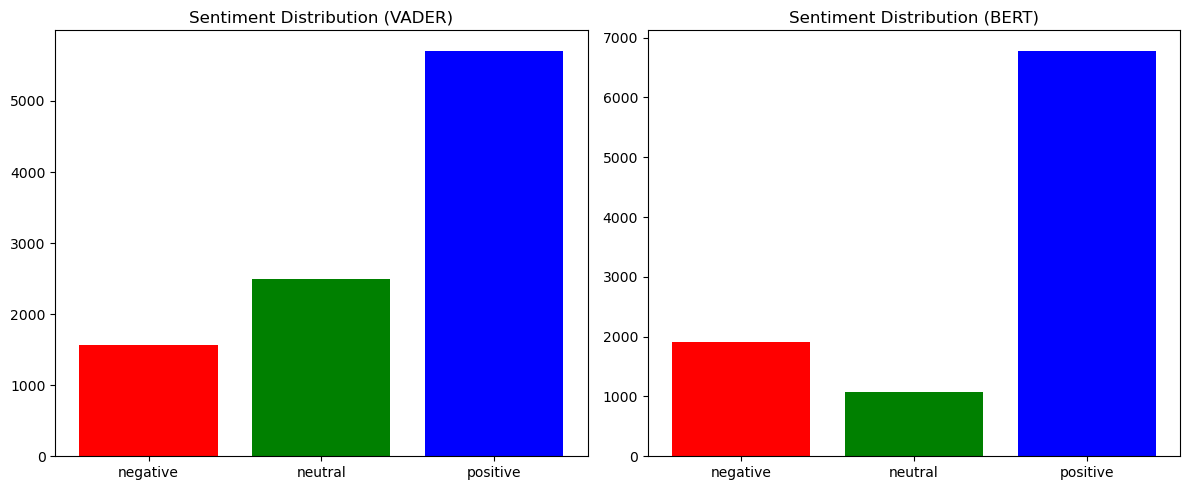

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(vader_labels['label_vader'], vader_labels['cnt_vader'], color=['red', 'green', 'blue'])
axes[0].set_title('Sentiment Distribution (VADER)')

bert_grouped = bert_labels.groupby("label_bert")["cnt_bert"].sum().reset_index()
axes[1].bar(bert_grouped['label_bert'], bert_grouped['cnt_bert'], color=['red', 'green', 'blue'])
axes[1].set_title('Sentiment Distribution (BERT)')

plt.tight_layout()
plt.show()

In [49]:
df.to_csv('/Users/gulsumasenacakir/Desktop/portfolio/sentiment_results.csv')